Segmentaion on shapenet data using pointnet - Part Segmentation


## Imports

In [ ]:
import os
import json
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from glob import glob

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt

## Downloading Dataset

The [ShapeNet dataset](https://shapenet.org/) is an ongoing effort to establish a richly-annotated,
large-scale dataset of 3D shapes. **ShapeNetCore V1 Version** is a subset of the full ShapeNet
dataset with clean single 3D models and manually verified category and alignment
annotations. It covers 55 common object categories, with about 51,300 unique 3D models.

For this example, we use one of the 12 object categories of
[PASCAL 3D+](http://cvgl.stanford.edu/projects/pascal3d.html),
included as part of the ShapenetCore dataset.

In [ ]:
dataset_url = "https://git.io/JiY4i"

dataset_path = keras.utils.get_file(
    fname="shapenet.zip",
    origin=dataset_url,
    cache_subdir="datasets",
    hash_algorithm="auto",
    extract=True,
    archive_format="auto",
    cache_dir="datasets",
)

## Loading the dataset

We parse the dataset metadata in order to easily map model categories to their
respective directories and segmentation classes to colors for the purpose of
visualization.

In [ ]:
with open("/tmp/.keras/datasets/PartAnnotation/metadata.json") as json_file:
    metadata = json.load(json_file)

print(metadata)

{'Airplane': {'directory': '02691156', 'lables': ['wing', 'body', 'tail', 'engine'], 'colors': ['blue', 'green', 'red', 'pink']}, 'Bag': {'directory': '02773838', 'lables': ['handle', 'body'], 'colors': ['blue', 'green']}, 'Cap': {'directory': '02954340', 'lables': ['panels', 'peak'], 'colors': ['blue', 'green']}, 'Car': {'directory': '02958343', 'lables': ['wheel', 'hood', 'roof'], 'colors': ['blue', 'green', 'red']}, 'Chair': {'directory': '03001627', 'lables': ['leg', 'arm', 'back', 'seat'], 'colors': ['blue', 'green', 'red', 'pink']}, 'Earphone': {'directory': '03261776', 'lables': ['earphone', 'headband'], 'colors': ['blue', 'green']}, 'Guitar': {'directory': '03467517', 'lables': ['head', 'body', 'neck'], 'colors': ['blue', 'green', 'red']}, 'Knife': {'directory': '03624134', 'lables': ['handle', 'blade'], 'colors': ['blue', 'green']}, 'Lamp': {'directory': '03636649', 'lables': ['canopy', 'lampshade', 'base'], 'colors': ['blue', 'green', 'red']}, 'Laptop': {'directory': '0364280

In this example, we train PointNet to segment the parts of an `Airplane` model.

In [ ]:
points_dir = "/tmp/.keras/datasets/PartAnnotation/{}/points".format(
    metadata["Motorbike"]["directory"]
)
labels_dir = "/tmp/.keras/datasets/PartAnnotation/{}/points_label".format(
    metadata["Motorbike"]["directory"]
)
LABELS = metadata["Motorbike"]["lables"]
COLORS = metadata["Motorbike"]["colors"]

VAL_SPLIT = 0.2
NUM_SAMPLE_POINTS = 1024
BATCH_SIZE = 32
EPOCHS = 60
INITIAL_LR = 1e-3

## Structuring the dataset

We generate the following in-memory data structures from the Airplane point clouds and
their labels:

- `point_clouds` is a list of `np.array` objects that represent the point cloud data in
the form of x, y and z coordinates. Axis 0 represents the number of points in the
point cloud, while axis 1 represents the coordinates. `all_labels` is the list
that represents the label of each coordinate as a string (needed mainly for
visualization purposes).
- `test_point_clouds` is in the same format as `point_clouds`, but doesn't have
corresponding the labels of the point clouds.
- `all_labels` is a list of `np.array` objects that represent the point cloud labels
for each coordinate, corresponding to the `point_clouds` list.
- `point_cloud_labels` is a list of `np.array` objects that represent the point cloud
labels for each coordinate in one-hot encoded form, corresponding to the `point_clouds`
list.

In [ ]:
point_clouds, test_point_clouds = [], []
point_cloud_labels, all_labels = [], []

points_files = glob(os.path.join(points_dir, "*.pts"))
for point_file in tqdm(points_files):
    point_cloud = np.loadtxt(point_file)
    if point_cloud.shape[0] < NUM_SAMPLE_POINTS:
        continue

    # Get the file-id of the current point cloud for parsing its
    # labels.
    file_id = point_file.split("/")[-1].split(".")[0]
    label_data, num_labels = {}, 0
    for label in LABELS:
        label_file = os.path.join(labels_dir, label, file_id + ".seg")
        if os.path.exists(label_file):
            label_data[label] = np.loadtxt(label_file).astype("float32")
            num_labels = len(label_data[label])

    # Point clouds having labels will be our training samples.
    try:
        label_map = ["none"] * num_labels
        for label in LABELS:
            for i, data in enumerate(label_data[label]):
                label_map[i] = label if data == 1 else label_map[i]
        label_data = [
            LABELS.index(label) if label != "none" else len(LABELS)
            for label in label_map
        ]
        # Apply one-hot encoding to the dense label representation.
        label_data = keras.utils.to_categorical(label_data, num_classes=len(LABELS) + 1)

        point_clouds.append(point_cloud)
        point_cloud_labels.append(label_data)
        all_labels.append(label_map)
    except KeyError:
        test_point_clouds.append(point_cloud)

100%|██████████| 337/337 [00:30<00:00, 10.87it/s]


Next, we take a look at some samples from the in-memory arrays we just generated:

In [ ]:
for _ in range(5):
    i = random.randint(0, len(point_clouds) - 1)
    print(f"point_clouds[{i}].shape:", point_clouds[0].shape)
    print(f"point_cloud_labels[{i}].shape:", point_cloud_labels[0].shape)
    for j in range(5):
        print(
            f"all_labels[{i}][{j}]:",
            all_labels[i][j],
            f"\tpoint_cloud_labels[{i}][{j}]:",
            point_cloud_labels[i][j],
            "\n",
        )

point_clouds[186].shape: (2778, 3)
point_cloud_labels[186].shape: (2778, 6)
all_labels[186][0]: none 	point_cloud_labels[186][0]: [0. 0. 0. 0. 0. 1.] 

all_labels[186][1]: wheel 	point_cloud_labels[186][1]: [1. 0. 0. 0. 0. 0.] 

all_labels[186][2]: wheel 	point_cloud_labels[186][2]: [1. 0. 0. 0. 0. 0.] 

all_labels[186][3]: gas_tank 	point_cloud_labels[186][3]: [0. 0. 1. 0. 0. 0.] 

all_labels[186][4]: none 	point_cloud_labels[186][4]: [0. 0. 0. 0. 0. 1.] 

point_clouds[118].shape: (2778, 3)
point_cloud_labels[118].shape: (2778, 6)
all_labels[118][0]: handle 	point_cloud_labels[118][0]: [0. 1. 0. 0. 0. 0.] 

all_labels[118][1]: none 	point_cloud_labels[118][1]: [0. 0. 0. 0. 0. 1.] 

all_labels[118][2]: none 	point_cloud_labels[118][2]: [0. 0. 0. 0. 0. 1.] 

all_labels[118][3]: none 	point_cloud_labels[118][3]: [0. 0. 0. 0. 0. 1.] 

all_labels[118][4]: wheel 	point_cloud_labels[118][4]: [1. 0. 0. 0. 0. 0.] 

point_clouds[146].shape: (2778, 3)
point_cloud_labels[146].shape: (2778, 6)
all

Now, let's visualize some of the point clouds along with their labels.

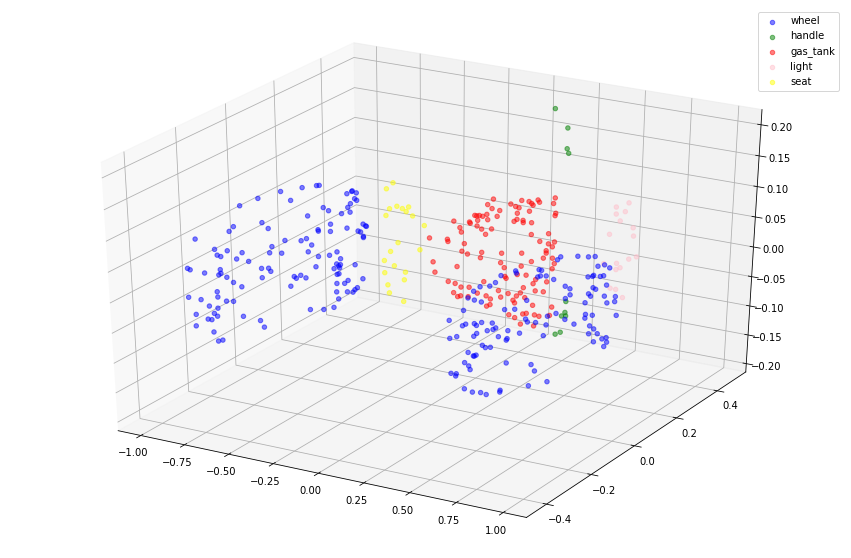

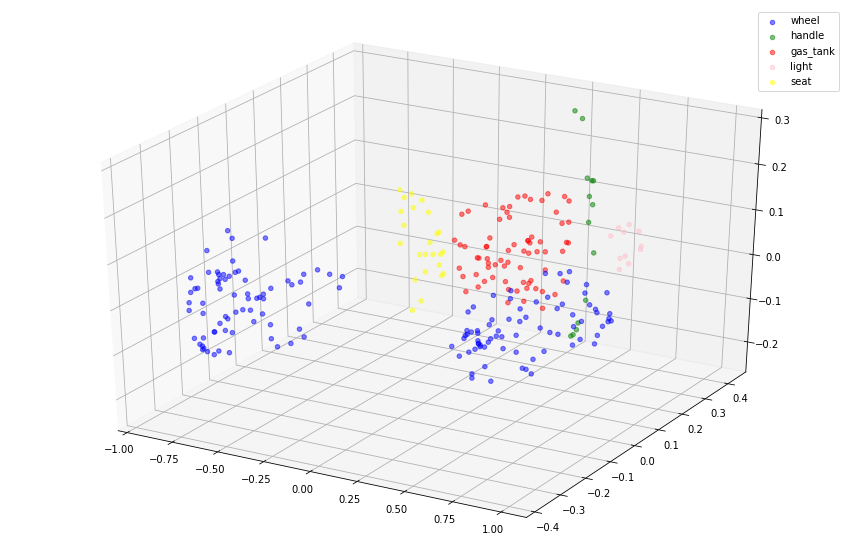

In [ ]:

def visualize_data(point_cloud, labels):
    df = pd.DataFrame(
        data={
            "x": point_cloud[:, 0],
            "y": point_cloud[:, 1],
            "z": point_cloud[:, 2],
            "label": labels,
        }
    )
    fig = plt.figure(figsize=(15, 10))
    ax = plt.axes(projection="3d")
    for index, label in enumerate(LABELS):
        c_df = df[df["label"] == label]
        try:
            ax.scatter(
                c_df["x"], c_df["y"], c_df["z"], label=label, alpha=0.5, c=COLORS[index]
            )
        except IndexError:
            pass
    ax.legend()
    plt.show()


visualize_data(point_clouds[0],all_labels[0])
visualize_data(point_clouds[25], all_labels[25])

Preprocessing- normalize

Preprocessing

point clouds that we have loaded consist of a variable number of points, which makes it difficult for us to batch them together. In order to overcome this problem, we randomly sample a fixed number of points from each point cloud. We also normalize the point clouds in order to make the data scale-invariant

In [ ]:
for index in tqdm(range(len(point_clouds))):
    current_point_cloud = point_clouds[index]
    current_label_cloud = point_cloud_labels[index]
    current_labels = all_labels[index]
    num_points = len(current_point_cloud)
    # Randomly sampling respective indices.
    sampled_indices = random.sample(list(range(num_points)), NUM_SAMPLE_POINTS)
    # Sampling points corresponding to sampled indices.
    sampled_point_cloud = np.array([current_point_cloud[i] for i in sampled_indices])
    # Sampling corresponding one-hot encoded labels.
    sampled_label_cloud = np.array([current_label_cloud[i] for i in sampled_indices])
    # Sampling corresponding labels for visualization.
    sampled_labels = np.array([current_labels[i] for i in sampled_indices])
    # Normalizing sampled point cloud.
    norm_point_cloud = sampled_point_cloud - np.mean(sampled_point_cloud, axis=0)
    norm_point_cloud /= np.max(np.linalg.norm(norm_point_cloud, axis=1))
    point_clouds[index] = norm_point_cloud
    point_cloud_labels[index] = sampled_label_cloud
    all_labels[index] = sampled_labels

100%|██████████| 234/234 [00:00<00:00, 350.19it/s]


Let's visualize the sampled and normalized point clouds along with their corresponding
labels.

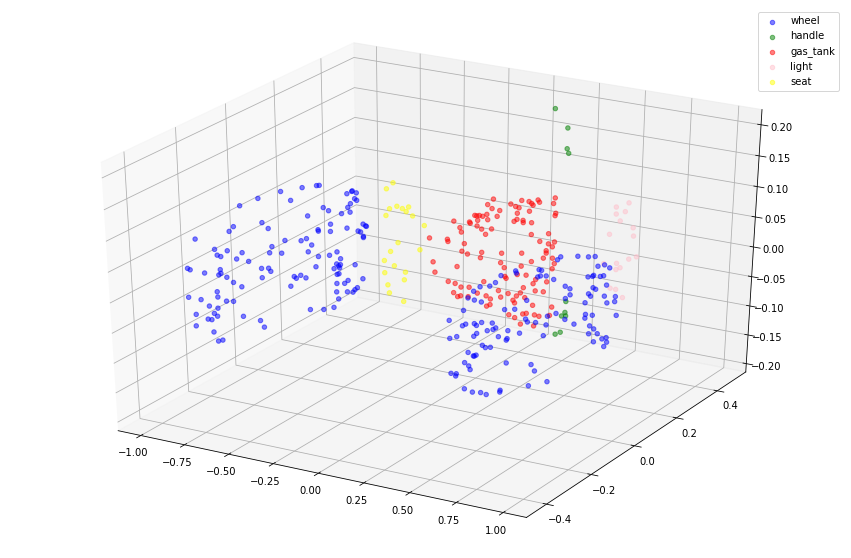

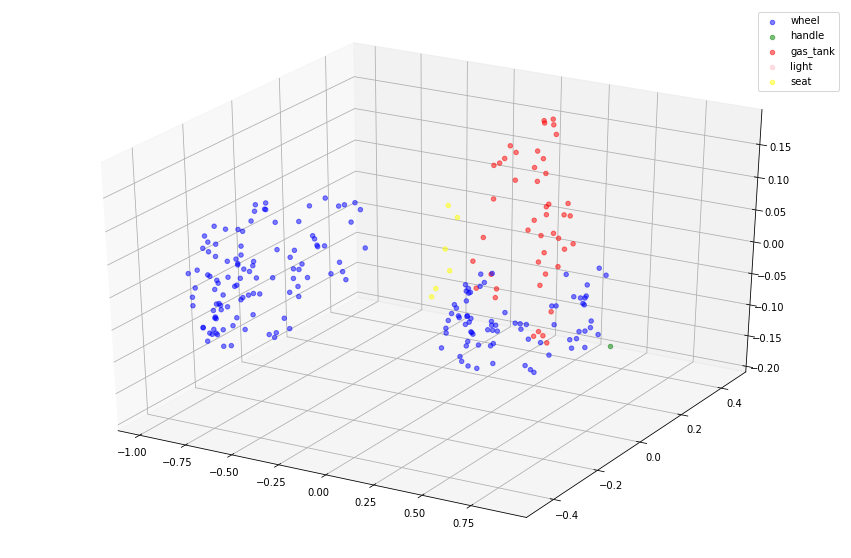

In [ ]:
visualize_data(point_clouds[0], all_labels[0])
visualize_data(point_clouds[50], all_labels[50])

trainng & validation

Creating TensorFlow datasets
Create tf.data.Dataset objects for the training and validation data. We also augment the training point clouds by applying random jitter to them.

Jittering is the act of adding random noise to data in order to prevent overplotting in statistical graphs.

In [ ]:

def load_data(point_cloud_batch, label_cloud_batch):
    point_cloud_batch.set_shape([NUM_SAMPLE_POINTS, 3])
    label_cloud_batch.set_shape([NUM_SAMPLE_POINTS, len(LABELS) + 1])
    return point_cloud_batch, label_cloud_batch


def augment(point_cloud_batch, label_cloud_batch):
    noise = tf.random.uniform(
        tf.shape(label_cloud_batch), -0.005, 0.005, dtype=tf.float64
    )
    point_cloud_batch += noise[:, :, :3]
    return point_cloud_batch, label_cloud_batch


def generate_dataset(point_clouds, label_clouds, is_training=True):
    dataset = tf.data.Dataset.from_tensor_slices((point_clouds, label_clouds))
    dataset = dataset.shuffle(BATCH_SIZE * 100) if is_training else dataset
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size=BATCH_SIZE)
    dataset = (
        dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
        if is_training
        else dataset
    )
    return dataset


split_index = int(len(point_clouds) * (1 - VAL_SPLIT))
train_point_clouds = point_clouds[:split_index]
train_label_cloud = point_cloud_labels[:split_index]
total_training_examples = len(train_point_clouds)

val_point_clouds = point_clouds[split_index:]
val_label_cloud = point_cloud_labels[split_index:]

print("Num train point clouds:", len(train_point_clouds))
print("Num train point cloud labels:", len(train_label_cloud))
print("Num val point clouds:", len(val_point_clouds))
print("Num val point cloud labels:", len(val_label_cloud))

train_dataset = generate_dataset(train_point_clouds, train_label_cloud)
val_dataset = generate_dataset(val_point_clouds, val_label_cloud, is_training=False)

print("Train Dataset:", train_dataset)
print("Validation Dataset:", val_dataset)

Num train point clouds: 187
Num train point cloud labels: 187
Num val point clouds: 47
Num val point cloud labels: 47
Train Dataset: <ParallelMapDataset element_spec=(TensorSpec(shape=(None, 1024, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1024, 6), dtype=tf.float32, name=None))>
Validation Dataset: <BatchDataset element_spec=(TensorSpec(shape=(None, 1024, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1024, 6), dtype=tf.float32, name=None))>


**PointNet Model**

implementing the basic blocks i.e., the convolutional block and the multi-layer
perceptron block.
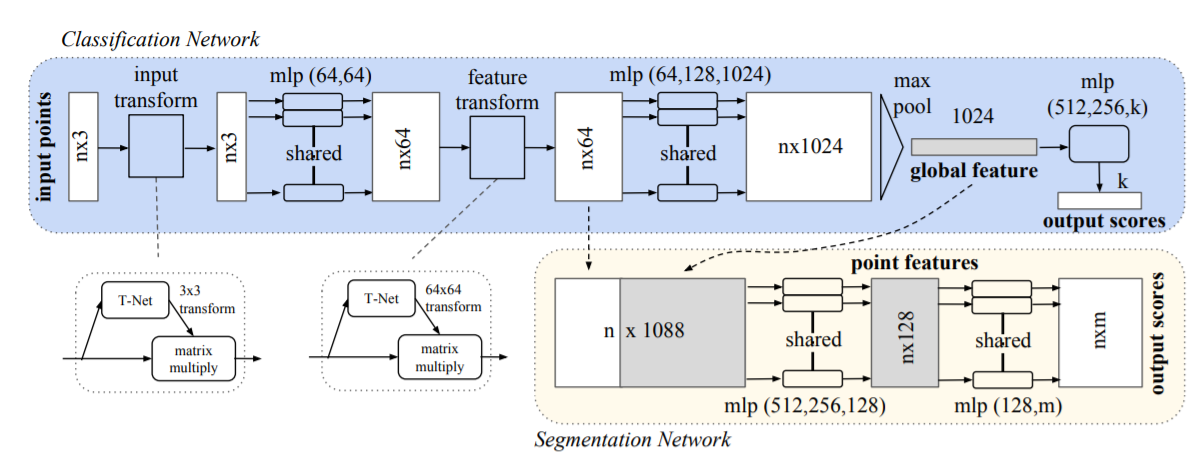

In [ ]:
# Convolutional Block
def conv_block(x: tf.Tensor, filters: int, name: str) -> tf.Tensor:
    x = layers.Conv1D(filters, kernel_size=1, padding="valid", name=f"{name}_conv")(x)
    x = layers.BatchNormalization(momentum=0.0, name=f"{name}_batch_norm")(x)
    return layers.Activation("relu", name=f"{name}_relu")(x)


In [ ]:
# MLP Block
def mlp_block(x: tf.Tensor, filters: int, name: str) -> tf.Tensor:
    x = layers.Dense(filters, name=f"{name}_dense")(x)
    x = layers.BatchNormalization(momentum=0.0, name=f"{name}_batch_norm")(x)
    return layers.Activation("relu", name=f"{name}_relu")(x)

Implement a regularizer (taken from this example) to enforce orthogonality in the feature space. This is needed to ensure that the magnitudes of the transformed features do not vary too much.

In [ ]:

class OrthogonalRegularizer(keras.regularizers.Regularizer):
    """Reference: https://keras.io/examples/vision/pointnet/#build-a-model"""

    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.identity = tf.eye(num_features)

    def __call__(self, x):
        x = tf.reshape(x, (-1, self.num_features, self.num_features))
        xxt = tf.tensordot(x, x, axes=(2, 2))
        xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
        return tf.reduce_sum(self.l2reg * tf.square(xxt - self.identity))

    def get_config(self):
        config = super(TransformerEncoder, self).get_config()
        config.update({"num_features": self.num_features, "l2reg_strength": self.l2reg})
        return config


 transformation network 

In [ ]:

def transformation_net(inputs: tf.Tensor, num_features: int, name: str) -> tf.Tensor:
    """
    Reference: https://keras.io/examples/vision/pointnet/#build-a-model.

    The `filters` values come from the original paper:
    https://arxiv.org/abs/1612.00593.
    """
    x = conv_block(inputs, filters=64, name=f"{name}_1")
    x = conv_block(x, filters=128, name=f"{name}_2")
    x = conv_block(x, filters=1024, name=f"{name}_3")
    x = layers.GlobalMaxPooling1D()(x)
    x = mlp_block(x, filters=512, name=f"{name}_1_1")
    x = mlp_block(x, filters=256, name=f"{name}_2_1")
    return layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=keras.initializers.Constant(np.eye(num_features).flatten()),
        activity_regularizer=OrthogonalRegularizer(num_features),
        name=f"{name}_final",
    )(x)


def transformation_block(inputs: tf.Tensor, num_features: int, name: str) -> tf.Tensor:
    transformed_features = transformation_net(inputs, num_features, name=name)
    transformed_features = layers.Reshape((num_features, num_features))(
        transformed_features
    )
    return layers.Dot(axes=(2, 1), name=f"{name}_mm")([inputs, transformed_features])


 above blocks together and implement the segmentation model.

In [ ]:

def get_shape_segmentation_model(num_points: int, num_classes: int) -> keras.Model:
    input_points = keras.Input(shape=(None, 3))

    # PointNet Classification Network.
    transformed_inputs = transformation_block(
        input_points, num_features=3, name="input_transformation_block"
    )
    features_64 = conv_block(transformed_inputs, filters=64, name="features_64")
    features_128_1 = conv_block(features_64, filters=128, name="features_128_1")
    features_128_2 = conv_block(features_128_1, filters=128, name="features_128_2")
    transformed_features = transformation_block(
        features_128_2, num_features=128, name="transformed_features"
    )
    features_512 = conv_block(transformed_features, filters=512, name="features_512")
    features_2048 = conv_block(features_512, filters=2048, name="pre_maxpool_block")
    global_features = layers.MaxPool1D(pool_size=num_points, name="global_features")(
        features_2048
    )
    global_features = tf.tile(global_features, [1, num_points, 1])

    # Segmentation head.
    segmentation_input = layers.Concatenate(name="segmentation_input")(
        [
            features_64,
            features_128_1,
            features_128_2,
            transformed_features,
            features_512,
            global_features,
        ]
    )
    segmentation_features = conv_block(
        segmentation_input, filters=128, name="segmentation_features"
    )
    outputs = layers.Conv1D(
        num_classes, kernel_size=1, activation="softmax", name="segmentation_head"
    )(segmentation_features)
    return keras.Model(input_points, outputs)


### Instantiate the model

In [ ]:
x, y = next(iter(train_dataset))

num_points = x.shape[1]
num_classes = y.shape[-1]

segmentation_model = get_shape_segmentation_model(num_points, num_classes)
segmentation_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 3)]    0           []                               
                                                                                                  
 input_transformation_block_1_c  (None, None, 64)    256         ['input_1[0][0]']                
 onv (Conv1D)                                                                                     
                                                                                                  
 input_transformation_block_1_b  (None, None, 64)    256         ['input_transformation_block_1_co
 atch_norm (BatchNormalization)                                  nv[0][0]']                       
                                                                                              

### Training the model

For the training the authors recommend using a learning rate schedule that decays the initial learning rate by half every 20 epochs. In this example, we resort to 15 epochs.

Total training steps: 300.


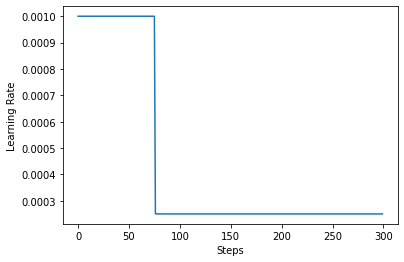

In [ ]:
training_step_size = total_training_examples // BATCH_SIZE
total_training_steps = training_step_size * EPOCHS
print(f"Total training steps: {total_training_steps}.")

lr_schedule = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[training_step_size * 15, training_step_size * 15],
    values=[INITIAL_LR, INITIAL_LR * 0.5, INITIAL_LR * 0.25],
)

steps = tf.range(total_training_steps, dtype=tf.int32)
lrs = [lr_schedule(step) for step in steps]

plt.plot(lrs)
plt.xlabel("Steps")
plt.ylabel("Learning Rate")
plt.show()

Finally, we implement a utility for running our experiments and launch model training.

In [ ]:
def run_experiment(epochs):

    segmentation_model = get_shape_segmentation_model(num_points, num_classes)
    segmentation_model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
        loss=keras.losses.CategoricalCrossentropy(),
        metrics=["accuracy"],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True,
    )

    history = segmentation_model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=epochs,
        callbacks=[checkpoint_callback],
    )

    segmentation_model.load_weights(checkpoint_filepath)
    return segmentation_model, history


segmentation_model, history = run_experiment(epochs=EPOCHS)

Epoch 1/60
6/6 [==============================] - 82s 12s/step - loss: 10.8001 - accuracy: 0.3697 - val_loss: 633.9131 - val_accuracy: 0.1727
Epoch 2/60
6/6 [==============================] - 75s 12s/step - loss: 6.4885 - accuracy: 0.6485 - val_loss: 61.6577 - val_accuracy: 0.6415
Epoch 3/60
6/6 [==============================] - 70s 12s/step - loss: 5.4963 - accuracy: 0.7176 - val_loss: 7.4909 - val_accuracy: 0.7337
Epoch 4/60
6/6 [==============================] - 71s 12s/step - loss: 5.1763 - accuracy: 0.7287 - val_loss: 365.5907 - val_accuracy: 0.5764
Epoch 5/60
6/6 [==============================] - 70s 12s/step - loss: 4.9140 - accuracy: 0.7385 - val_loss: 36.2486 - val_accuracy: 0.7350
Epoch 6/60
6/6 [==============================] - 71s 12s/step - loss: 4.8267 - accuracy: 0.7459 - val_loss: 4.8865 - val_accuracy: 0.7262
Epoch 7/60
6/6 [==============================] - 70s 12s/step - loss: 4.7300 - accuracy: 0.7526 - val_loss: 4.9932 - val_accuracy: 0.7480
Epoch 8/60
6/6 [====

### Visualize the training landscape

accuracy


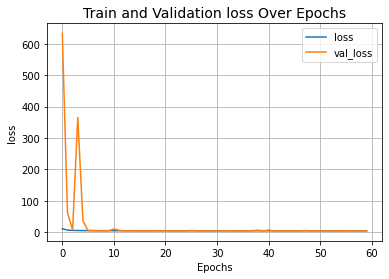

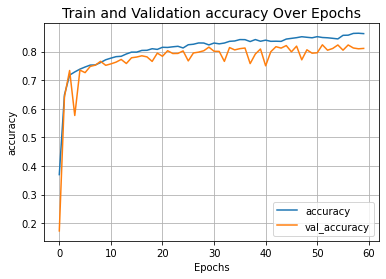

In [ ]:

def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()

print('accuracy')
plot_result("loss")
plot_result("accuracy")

### Inference

Validation prediction shape: (32, 1024, 6)
Index selected: 6


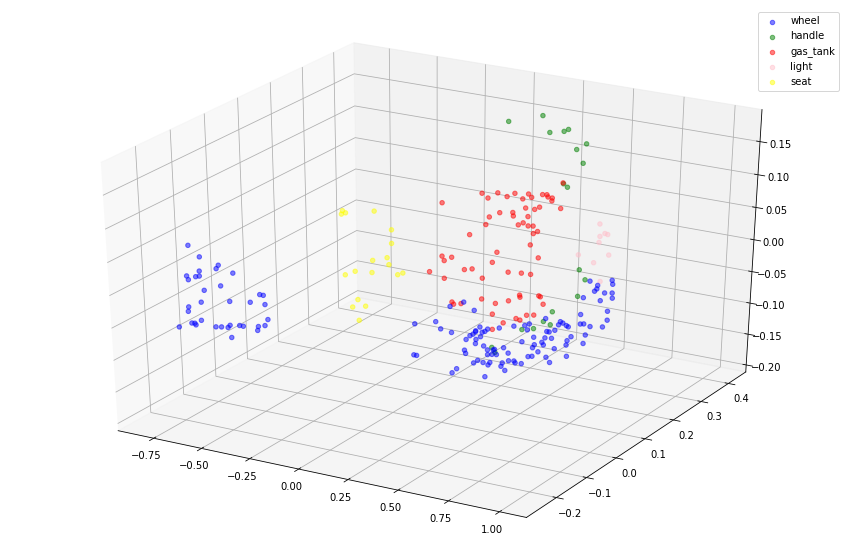

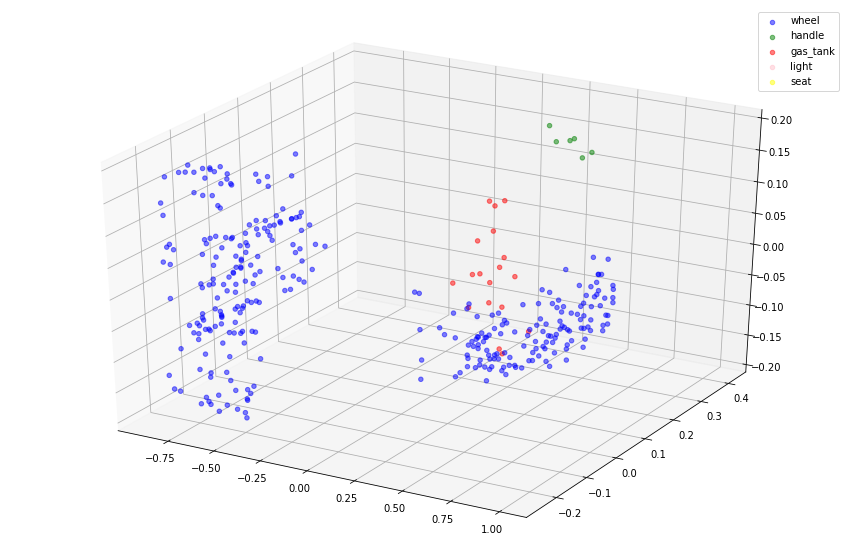

In [ ]:
validation_batch = next(iter(val_dataset))
val_predictions = segmentation_model.predict(validation_batch[0])
print(f"Validation prediction shape: {val_predictions.shape}")


def visualize_single_point_cloud(point_clouds, label_clouds, idx):
    label_map = LABELS + ["none"]
    point_cloud = point_clouds[idx]
    label_cloud = label_clouds[idx]
    visualize_data(point_cloud, [label_map[np.argmax(label)] for label in label_cloud])


idx = np.random.choice(len(validation_batch[0]))
print(f"Index selected: {idx}")

# Plotting with ground-truth.
visualize_single_point_cloud(validation_batch[0], validation_batch[1], idx)

# Plotting with predicted labels.
visualize_single_point_cloud(validation_batch[0], val_predictions, idx)

In [ ]:
# Shapenet official train/test split
DATA_PATH = os.path.join(ROOT_DIR, 'data', 'shapenetcore_partanno_segmentation_benchmark_v0_normal')
TRAIN_DATASET = part_dataset_all_normal.PartNormalDataset(root=DATA_PATH, npoints=NUM_POINT, classification=False, split='trainval', return_cls_label=True)
TEST_DATASET = part_dataset_all_normal.PartNormalDataset(root=DATA_PATH, npoints=NUM_POINT, classification=False, split='test', return_cls_label=True)

NameError: ignored

## Training

validate 

original vs predicted

In [ ]:
# Python code to find Euclidean distance
# using linalg.norm()
 
import numpy as np
 
# initializing points in
# numpy arrays
point1 = np.array((1, 2, 3))
point2 = np.array((1, 1, 1))
 
# calculating Euclidean distance
# using linalg.norm()
dist = np.linalg.norm(point1 - point2)
 
# printing Euclidean distance
print(dist)

2.23606797749979


In [ ]:
import os
import json
import random
import numpy as np
import pandas as pd

from glob import glob
from tqdm import tqdm

import tensorflow as tf
import plotly.express as px
import matplotlib.pyplot as plt


class ShapeNetCoreLoaderInMemory:
    """
    In-memory Dataloader class for Shapenet Core Dataset. This dataloader 
    was built primarily for EDA purposes and hence has good support for 
    visualization. This dataloader loads all the point clouds and corresponding 
    label clouds as in-memory data structures which are subsequently used to 
    generate the TensorFlow BatchDatasets.

    Args:
        object_category (str): One of the 12 objects from the ShapenetCore dataset.
        n_sampled_points (int): Number of points to be sampled from each point cloud.
        viz_samples: Number of samples to be loaded for visualization (optional).  
    """

    def __init__(
        self,
        object_category: str = "Airplane",
        n_sampled_points: int = 1024,
        viz_samples=None,
    ) -> None:
        self._get_files()
        self.dataset_path = "/tmp/.keras/datasets/PartAnnotation"
        self.metadata = self._load_metadata()
        if object_category not in self.metadata.keys():
            raise KeyError(
                "Not a valid Shapenet Object. Must be one of "
                + str(self.metadata.keys())
            )
        else:
            self.object_category = object_category
        self.n_sampled_points = n_sampled_points
        self.point_clouds, self.test_point_clouds = [], []
        self.point_cloud_labels, self.all_labels = [], []
        self.point_cloud_dataframes = []
        self.labels = self.metadata[self.object_category]["lables"]
        self.colors = self.metadata[self.object_category]["colors"]
        self.viz_samples = viz_samples

    def _get_files(self):
        dataset_url = "https://github.com/soumik12345/point-cloud-segmentation/releases/download/v0.1/shapenet.zip"
        tf.keras.utils.get_file(
            fname="shapenet.zip",
            origin=dataset_url,
            cache_subdir="datasets",
            hash_algorithm="auto",
            extract=True,
            archive_format="auto",
            cache_dir="datasets",
        )

    def _load_metadata(self):
        with open(os.path.join(self.dataset_path, "metadata.json")) as json_file:
            metadata = json.load(json_file)
        return metadata

    def _sample_points(self):
        for index in tqdm(range(len(self.point_clouds))):
            current_point_cloud = self.point_clouds[index]
            current_label_cloud = self.point_cloud_labels[index]
            current_labels = self.all_labels[index]
            n_points = len(current_point_cloud)
            # Randomly sampling respective indices
            sampled_indices = random.sample(
                list(range(n_points)), self.n_sampled_points
            )
            # Sampling points corresponding to sampled indices
            sampled_point_cloud = np.array(
                [current_point_cloud[i] for i in sampled_indices]
            )
            # Sampling corresponding one-hot encoded labels
            sampled_label_cloud = np.array(
                [current_label_cloud[i] for i in sampled_indices]
            )
            # Sampling corresponding labels for visualization
            sampled_labels = np.array([current_labels[i] for i in sampled_indices])
            # Normalizing sampled point cloud
            normalized_point_cloud = sampled_point_cloud - np.mean(
                sampled_point_cloud, axis=0
            )
            normalized_point_cloud /= np.max(
                np.linalg.norm(normalized_point_cloud, axis=1)
            )
            self.point_clouds[index] = normalized_point_cloud
            self.point_cloud_labels[index] = sampled_label_cloud
            self.all_labels[index] = sampled_labels

    def load_data(self):
        """
        Function to load the ShapeNet Core Point Cloud and Label Cloud into the primary memory.
        """
        points_dir = os.path.join(
            self.dataset_path,
            "{}/points".format(self.metadata[self.object_category]["directory"]),
        )
        labels_dir = os.path.join(
            self.dataset_path,
            "{}/points_label".format(self.metadata[self.object_category]["directory"]),
        )

        points_files = glob(os.path.join(points_dir, "*.pts"))
        if self.viz_samples:
            points_files = points_files[: self.viz_samples]

        for point_file in tqdm(points_files):
            point_cloud = np.loadtxt(point_file)
            if point_cloud.shape[0] < self.n_sampled_points:
                continue
            file_id = point_file.split("/")[-1].split(".")[0]
            label_data, num_labels = {}, 0
            for label in self.labels:
                label_file = os.path.join(labels_dir, label, file_id + ".seg")
                if os.path.exists(label_file):
                    label_data[label] = np.loadtxt(label_file).astype("float32")
                    num_labels = len(label_data[label])
            try:
                label_map = ["none"] * num_labels
                for label in self.labels:
                    for i, data in enumerate(label_data[label]):
                        label_map[i] = label if data == 1 else label_map[i]
                label_data = [
                    self.labels.index(label) if label != "none" else len(self.labels)
                    for label in label_map
                ]
                label_cloud = tf.keras.utils.to_categorical(
                    label_data, num_classes=len(self.labels) + 1
                )
                self.point_clouds.append(point_cloud)
                self.point_cloud_labels.append(label_cloud)
                self.all_labels.append(label_map)
                self.point_cloud_dataframes.append(
                    pd.DataFrame(
                        data={
                            "x": point_cloud[:, 0],
                            "y": point_cloud[:, 1],
                            "z": point_cloud[:, 2],
                            "label": label_map,
                        }
                    )
                )
            except KeyError:
                # Use point cloud files without labels as test data.
                self.test_point_clouds.append(point_cloud)

    def visualize_data_plotly(self, index):
        """
        Function to visualize the point cloud and corresponding labels using Plotly.
        """
        fig = px.scatter_3d(
            self.point_cloud_dataframes[index],
            x="x",
            y="y",
            z="z",
            color="label",
            labels={"label": "Label"},
            color_discrete_sequence=self.colors,
            category_orders={"label": self.labels},
        )
        fig.show()

    def visualize_data_plt(self, index):
        """
        Function to visualize the point cloud and corresponding labels using Matplotlib.
        """
        df = self.point_cloud_dataframes[index]
        fig = plt.figure(figsize=(15, 10))
        ax = plt.axes(projection="3d")
        for index, label in enumerate(self.labels):
            c_df = df[df["label"] == label]
            try:
                ax.scatter(
                    c_df["x"],
                    c_df["y"],
                    c_df["z"],
                    label=label,
                    alpha=0.5,
                    c=self.colors[index],
                )
            except IndexError:
                pass
        ax.legend()
        plt.show()

    def _load_data(self, point_cloud_batch, label_cloud_batch):
        point_cloud_batch.set_shape([self.n_sampled_points, 3])
        label_cloud_batch.set_shape([self.n_sampled_points, len(self.labels) + 1])
        return point_cloud_batch, label_cloud_batch

    def _augment(self, point_cloud_batch, label_cloud_batch):
        """Jitter point and label clouds."""
        noise = tf.random.uniform(
            tf.shape(label_cloud_batch), -0.005, 0.005, dtype=tf.float64
        )
        point_cloud_batch += noise[:, :, :3]
        return point_cloud_batch, label_cloud_batch

    def _generate_dataset(
        self, point_clouds, label_clouds, batch_size: int, is_training: bool
    ):
        dataset = tf.data.Dataset.from_tensor_slices((point_clouds, label_clouds))
        dataset = dataset.shuffle(batch_size * 100) if is_training else dataset
        dataset = dataset.map(self._load_data, num_parallel_calls=tf.data.AUTOTUNE)
        dataset = dataset.batch(batch_size=batch_size)
        dataset = (
            dataset.map(self._augment, num_parallel_calls=tf.data.AUTOTUNE)
            if is_training
            else dataset
        )
        return dataset

    def get_datasets(self, val_split: float = 0.2, batch_size: int = 16):
        """
        Get TensorFlow BatchDataset objects for train and validation data.

        Args:
            val_split (str): Fraction representing validation split (default=0.2).
            batch_size (int): Batch size for training and validation (default=16).
        
        Returns:
            train_dataset (TensorFlow BatchDataset): Train dataset,
            val_dataset (TensorFlow BatchDataset): Validation dataset
        """
        self._sample_points()
        split_index = int(len(self.point_clouds) * (1 - val_split))
        train_point_clouds = self.point_clouds[:split_index]
        train_point_cloud_labels = self.point_cloud_labels[:split_index]
        val_point_clouds = self.point_clouds[split_index:]
        val_point_cloud_labels = self.point_cloud_labels[split_index:]
        train_dataset = self._generate_dataset(
            train_point_clouds, train_point_cloud_labels, batch_size, is_training=True
        )
        val_dataset = self._generate_dataset(
            val_point_clouds, val_point_cloud_labels, batch_size, is_training=False
        )
        return train_dataset, val_dataset

In [ ]:

def visualize_data_plotly(self, index):
        """
        Function to visualize the point cloud and corresponding labels using Plotly.
        """
        fig = px.scatter_3d(
            self.point_cloud_dataframes[index],
            x="x",
            y="y",
            z="z",
            color="label",
            labels={"label": "Label"},
            color_discrete_sequence=self.colors,
            category_orders={"label": self.labels},
        )
        fig.show()

In [ ]:
r"""Train a Pointnet-based Shape Segmentation Model.

Sample Usage:
python train_shapenet_core.py --experiment_configs configs/shapenetcore.py
"""

import os
!pip install wandb
import wandb.keras
from absl import app
from absl import flags
from absl import logging
from datetime import datetime
!pip install ml_collections
from ml_collections.config_flags import config_flags

from tensorflow.keras import optimizers, callbacks
from tensorflow.keras import mixed_precision

!pip install point_seg
from point_seg import TFRecordLoader, ShapeNetCoreLoaderInMemory
from point_seg import models, utils


FLAGS = flags.FLAGS
flags.DEFINE_string("wandb_project_name", "pointnet_shapenet_core", "W&B Project Name.")
flags.DEFINE_string("use_wandb", True, "If we are using WandB.")
config_flags.DEFINE_config_file("experiment_configs")


def main(_):
    if FLAGS.experiment_configs.in_memory and FLAGS.experiment_configs.use_tpus:
        raise ValueError(
            "In-Memory Data Loading cannot be used with TPUs. Please use GCS."
        )

    # Get the current timestamp
    timestamp = datetime.utcnow().strftime("%y%m%d-%H%M%S")

    # Detect strategy
    strategy = utils.initialize_device()
    batch_size = FLAGS.experiment_configs.batch_size * strategy.num_replicas_in_sync
    FLAGS.experiment_configs["batch_size"] = batch_size

    # Determine the artifact location
    if not FLAGS.experiment_configs.use_tpus:
        FLAGS.experiment_configs.artifact_location = "."

    # Initialize W&B
    if FLAGS.use_wandb:
        wandb.login()
        utils.init_wandb(
            FLAGS.wandb_project_name,
            f"{FLAGS.experiment_configs.object_category}_{timestamp}",
            FLAGS.experiment_configs.to_dict(),
        )

    # Set precision.
    if FLAGS.experiment_configs.use_mp and not FLAGS.experiment_configs.use_tpus:
        mixed_precision.set_global_policy("mixed_float16")
        logging.info("Using mixed-precision.")
        policy = mixed_precision.global_policy()
        assert policy.compute_dtype == "float16"
        assert policy.variable_dtype == "float32"
    elif FLAGS.experiment_configs.use_mp and FLAGS.experiment_configs.use_tpus:
        raise ValueError(
            "TPUs run with mixed-precision by default. No need to specify precision separately."
        )

    # Define Dataloader
    logging.info(
        f"Object category received: {FLAGS.experiment_configs.object_category}."
    )
    logging.info(f"Preparing data loader with a batch size of {batch_size}.")
    train_dataset, val_dataset = None, None
    if FLAGS.experiment_configs.in_memory:
        data_loader = ShapeNetCoreLoaderInMemory(
            object_category=FLAGS.experiment_configs.object_category,
            n_sampled_points=FLAGS.experiment_configs.num_points,
        )
        data_loader.load_data()
        train_dataset, val_dataset = data_loader.get_datasets(
            val_split=FLAGS.experiment_configs.val_split,
            batch_size=FLAGS.experiment_configs.batch_size,
        )
    else:
        tfrecord_loader = TFRecordLoader(
            tfrecord_dir=os.path.join(
                FLAGS.experiment_configs.artifact_location, "tfrecords"
            ),
            object_category=FLAGS.experiment_configs.object_category,
        )
        drop_remainder = True if FLAGS.experiment_configs.use_tpus else False
        train_dataset, val_dataset = tfrecord_loader.get_datasets(
            batch_size=batch_size, drop_remainder=drop_remainder
        )

    # Learning Rate scheduling callback
    logging.info("Initializing callbacks.")
    lr_scheduler = utils.StepDecay(
        FLAGS.experiment_configs.initial_lr,
        FLAGS.experiment_configs.drop_every,
        FLAGS.experiment_configs.decay_factor,
    )
    lr_callback = callbacks.LearningRateScheduler(
        lambda epoch: lr_scheduler(epoch), verbose=True
    )

    # Tensorboard Callback
    logs_dir = os.path.join(
        "logs", f"{FLAGS.experiment_configs.object_category}_{timestamp}"
    )
    logs_dir = os.path.join(FLAGS.experiment_configs.artifact_location, logs_dir)
    tb_callback = callbacks.TensorBoard(log_dir=logs_dir)

    # Model Checkpoint Callback
    checkpoint_path = os.path.join(
        FLAGS.experiment_configs.artifact_location,
        "training_checkpoints",
        f"{FLAGS.experiment_configs.object_category}_{timestamp}",
    )
    checkpoint_callback = callbacks.ModelCheckpoint(
        filepath=checkpoint_path, save_best_only=True, save_weights_only=True,
    )

    # Pack the callbacks as a list.
    callback_list = [tb_callback, checkpoint_callback, lr_callback]
    if FLAGS.wandb_api_key is not None:
        callback_list.append(wandb.keras.WandbCallback())

    # Define Model and Optimizer
    with strategy.scope():
        logging.info("Initializing segmentation model.")
        optimizer = optimizers.Adam(learning_rate=FLAGS.experiment_configs.initial_lr)
        _, y = next(iter(train_dataset))
        num_classes = y.shape[-1]
        model = models.get_shape_segmentation_model(
            FLAGS.experiment_configs.num_points, num_classes
        )

    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )

    # Train
    logging.info("Beginning training.")
    model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=FLAGS.experiment_configs.epochs,
        callbacks=callback_list,
    )
    logging.info("Training complete, serializing model with the best checkpoint.")
    serialization_path = os.path.join(
        FLAGS.experiment_configs.artifact_location,
        "final_models",
        f"{FLAGS.experiment_configs.object_category}_{timestamp}",
    )

    # Since the model contains a custom regularizer, during loading the model we need to do the following:
    # model = keras.models.load_model(filepath,
    #   custom_objects={"OrthogonalRegularizer": transform_block.OrthogonalRegularizer}
    # )
    model.load_weights(checkpoint_path)
    model.save(serialization_path)
    logging.info(f"Model serialized to {serialization_path}.")


if __name__ == "__main__":
    app.run(main)

     |████████████████████████████████| 77 kB 3.1 MB/s 
  Created wheel for ml-collections: filename=ml_collections-0.1.1-py3-none-any.whl size=94524 sha256=5bb64cb28e8bff5fffefdbbd55d314e9a33cc9fba5a4aba535fd8f9c3ed17134
  Stored in directory: /root/.cache/pip/wheels/b7/da/64/33c926a1b10ff19791081b705879561b715a8341a856a3bbd2
Successfully built ml-collections


ModuleNotFoundError: ignored